## Proposal:

### *Environment: (dependent on the user)*

**States:** two dimensions: **tilt** and **closeness** to the screen. 
- Along the **tilt** dimension, we have discretized the head roll angle to three possible values: *left*, *normal* and *right*. 
- Along the **closeness** dimension (*y* coordinate from the tablet) we can either have a *normal* distance or *too close* (below a certain threshold)

This forms a 2x3 state space, where the only valid posture that does not trigger the intervention is (normal, normal). The thing is that then, $p_{EC}$ and $p_{EA}$ should be incorporated in the transition matrix as the probability of getting from some state to the *normal* state (the probability of the intervention actually working, from each state and for each action/intervention). 

<img src="states.png" alt="state space" width="400"/>


**Actions:** **EC**, **EA**, **DO NOTHING**.
- Instead of $p_{EC}$ and $p_{EA}$ from k-armed bandit, which denoted the success of the respective strategies, we model them through the transition matrix.
- "Do nothing" should model the agent applying no intervention if the current state is (normal, normal). The transition probabilities for this action are decaying as the time passes, modeling the fatigue of the user.

The question is: How to define iterations then? Is that the possibility of going from a normal state to other states? We need an action of doing nothing, and a high probability of going from the normal state to others,... while also that probability should get higher as the experiment goes on...
The problem also is the fact that a person can move from state to state regardless of the fact that our agent has taken an action or not... That is especially the case if the state is normal - our agent might learn to do nothing, but how do we impose that it actually goes to some other state, is it by transition matrix and a possibility of it going to some other state even though from neutal doing nothing should take you to a neutral state?

**Reward system:**

Rewards depend on the current state, action taken, and the next state. The logic was as follows:
- As for the intervention actions, EC and EA, if the current state is in bad posture (states 0,1,2,3,5), we define rewards w.r.t the next state we end up in as: next state has both state dimensions as non-normal, then the reward is -1; if one dimension is normal, the reward is -0.5 and if we end up in (normal,normal) state (state 4), the reward is 1. If the current state is normal posture (state 4) then if we end up in a non-normal state the reward is -1 (we wanted to penalize the agent for leaving the normal state) and if we end up in a normal state again, then the reward is 0 (the agent applied a corrective action without necessity, it is by chance that we stayed in the normal state)
- For the action DO NOTHING and starting from non-normal states, we penalize with -1 ending up in any non-normal state (the agent should have applied the intervention), and if we end up in the normal state, we assign a reward of 0 (it is the environment's stochasticity that lead us to normality, not the agent). When starting from a normal state, we reward the agent with 1 if he stays there (indeed he needed not to do anything), and with 0 if he ends up in a bad posture state (to mimic the movement of a real user; it's not the agent' fault)

**Non-episodic learning:** We start from Q values set to zero each time, this means that we don't learn anything from experiment to experiment

### Additional remarks:

*Transition matrix*: Since we added DO NOTHING action, which still has probabilities of ending up in any state of the environment, it should model the stochasticity such as user moving randomly. We set the diagonal of the transition matrix to high values at the beginning (the user will probably not move from the current state if the agent does nothing), but as the experiment progresses, these probabilities get lower and lower (transition_decay) modeling e.g. the user's fatigue.

*Non-episodic learning*: Since in paper they say: "We cannot draw a conclusive conclusion about whether children's understanding of the intervention strategy influences the effectiveness of the system. Further experiments are still required.", maybe for now we do not simulate a single user doing the experiment multiple times. If we end up deciding to do so, then we have to create an agent for every user, which will learn from experiment to experiment, that won't be non-episodic learning anymore... 

*User class*: Maybe to make a user class that has its own transition matrix that is user-dependent. Also, if we decide to do an episodic learning (i.e. the user has already taken the experiment in the past), we should save the Q-values after each experiment (episode) and start from these when running a new one for this user.


In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' # Keep using keras-2 (tf-keras) rather than keras-3 (keras).

import numpy as np
import matplotlib.pyplot as plt

from abc import abstractmethod
from typing import List

In [22]:
# Encode actions as integers:
EC = 0
EA = 1
DO_NOTHING = 2

NORMAL_STATE = 4

In [23]:
class WUREnvironment():

    def __init__(self, transition_model, p_aha, lambda_=0.01, p_aha_factor = 1.001):
        # Defining the number of states
        self._num_states = 6
        # Defining the number of actions
        self._num_actions = 2
        # Discount factor
        self._gamma = 0.99

        # Decaying factor for DO NOTHING action in transition matrix
        self._lambda = lambda_
        # By how much to increase the probability of AHA moment when the user gets it
        self._p_aha_factor = p_aha_factor

        # User specifications - transition matrix
        self._T = transition_model # shape = (num_actions, num_states, num_states); Dependent on the user -> given externally
        # User specifications - p_aha
        self._p_aha = p_aha
        
        # TODO: Remove or not to remove
        # Reward system matrix (num_actions, num_states, num_states)
        self._reward = np.array([
            [
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-1,-1,-1,0,-1],
                [-1,-0.5,-1,-0.5,1,-0.5]
            ], # EC
            [
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-1,-1,-1,0,-1],
                [-1,-0.5,-1,-0.5,1,-0.5]
            ], # EA
            [
                [-1,-1,-1,-1,0,-1],
                [-1,-1,-1,-1,0,-1],
                [-1,-1,-1,-1,0,-1],
                [-1,-1,-1,-1,0,-1],
                [0,0,0,0,1,0],
                [-1,-1,-1,-1,0,-1]
            ] # DO_NOTHING
        ]) 
        
        self._current_state = NORMAL_STATE # the default (normal, normal) state
        self._step_count = 0

    # We model the fatigue factor as e^{-lambda}. It multiplies the probabilities of staying in the same state
    # when no action is taken.
    def _fatigue(self):
        return np.exp(-self._lambda)

    def _decay_transitions(self):
        for i in range(self._num_states):
            decay_update = self._T[DO_NOTHING][i, i] * self._fatigue()
            assert decay_update > 0.5
            self._T[DO_NOTHING][i, i] = decay_update

            mask = np.ones(self._num_states, dtype=bool)
            mask[i] = False
            normalization_factor = (1 - self._T[DO_NOTHING][i, i]) / np.sum(self._T[DO_NOTHING][i, mask])
            self._T[DO_NOTHING][i, mask] *= normalization_factor
            
        assert np.sum(self._T[2], axis=1).all() == 1

    def step(self, action):
        """
        Inputs:
        action - chosen action of the step with eps-greedy exploration
        alpha - a.k.a. learning_rate
        """
        # To which state next does the action take us?
        new_state = np.random.choice(np.arange(self._num_states), p=self._T[action][self._current_state])
        
        # If we applied EA, we give user a chance to have an AHA moment
        if action == EA:
            self._p_aha[self._current_state] *= self._p_aha_factor
            new_state = NORMAL_STATE if np.random.uniform() < self._p_aha[self._current_state] else new_state

        previous_state = self._current_state
        self._current_state = new_state
        
        self._decay_transitions()
        self._step_count += 1
        
        return previous_state

In [24]:
class EpsGreedyAgent:
    def __init__(self, env: WUREnvironment, explore_rate = 1.0):
        self._num_actions = env._num_actions
        self._num_states = env._num_states
        self._env = env

        # Initialization of Q and N
        self._Q = np.zeros(shape=(self._num_states, self._num_actions), dtype=float)
        self._N = np.zeros((self._num_states, self._num_actions), dtype=int)

        self._step_counts = 0
        self._explore = explore_rate  
        self._reward_history = []

    def argmax_with_random_tie_breaking(self, b):
        return np.random.choice(np.where(b == b.max())[0])

    def select_action(self, state):
        # Should be selected on the basis of epsilon greedy from the current state
        explore = np.random.binomial(2, p=self._explore)
        if explore:
            # Exploration: With probability epsilon take a random action, an index of an action
            a = np.random.choice(np.arange(self._num_actions))
        else:
            # Exploitation: With probability 1 - epsilon take one of the optimal actions for the current state
            a = self.argmax_with_random_tie_breaking(self._Q[state, :])
        return a

    @abstractmethod
    def update_estimates(self, action, reward, prev_state):
        pass
    
    def get_current_average_reward(self):
        return np.mean(self._reward_history)
    
    def get_cumulative_reward(self):
        return np.sum(self._reward_history)

In [25]:
class QEpsGreedyAgent(EpsGreedyAgent):
    def update_estimates(self, action, reward, prev_state):
        
        """
        Updates the values of action counts, step counts, reward history etc.

        Inputs:
        action - action taken in the current step
        reward - reward collected while taking the step when interacting with the environment
        alpha - 
        """
        curr_state = self._env._current_state

        # Interaction with the environment - collecting reward 
        self._reward_history.append(reward)

        self._N[prev_state, action] += 1
        alpha = 0.5 / (self._N[prev_state, action] + 1) ** 0.75

        # Update Q according to the algorithm
        self._Q[prev_state, action] = \
            (1 - alpha) * self._Q[prev_state, action] + alpha * (reward + self._env._gamma*np.max(self._Q[curr_state, :]))        
        
        self._step_counts += 1
        return None

In [26]:
class SARSAEpsGreedyAgent(EpsGreedyAgent):
    def update_estimates(self, action, reward, prev_state):
        """
        Updates the values of action counts, step counts, reward history etc.

        Inputs:
        action - action taken in the current step
        reward - reward collected while taking the step when interacting with the environment
        alpha - 
        """
        curr_state = self._env._current_state

        # Interaction with the environment - collecting reward 
        self._reward_history.append(reward)

        self._N[prev_state, action] += 1
        alpha = 0.5 / (self._N[prev_state, action] + 1) ** 0.75

        # Sampling a new action
        new_action = self.select_action(curr_state)
        # Update Q according to the algorithm
        self._Q[prev_state, action] = (1 - alpha) * self._Q[prev_state, action] + alpha * (reward + self._env._gamma*self._Q[curr_state, new_action])
        
        self._step_counts += 1
        return new_action

In [27]:
class User:
    def __init__(self, base_transition_model, lambda_, p_aha, p_aha_factor, posture_change_factor):
        self._transition_model = self._initialize_transition_model(base_transition_model, posture_change_factor)
        self._lambda = lambda_
        self._p_aha = p_aha
        self._p_aha_factor = p_aha_factor
        self._posture_change_factor = posture_change_factor

    def _initialize_transition_model(self, base_transition_model, posture_change_factor):
        num_states = base_transition_model.shape[1]
        transition_model = base_transition_model.copy()

        # Modify the EA transition
        transition_model[EA] += np.random.normal(0, 0.05, size=(num_states, num_states))
        transition_model[EA] = np.abs(transition_model[EA])
        transition_model[EA] /= np.sum(transition_model[EA], axis=1)[:, np.newaxis]
        assert np.sum(transition_model[EA], axis=1).all() == 1
                                                                     
        # Modify the DO_NOTHING transition
        for i in range(num_states):
            transition_model[DO_NOTHING][i, i] *= posture_change_factor
            
            mask = np.ones(num_states, dtype=bool)
            mask[i] = False
            normalization_factor = (1 - transition_model[DO_NOTHING][i, i]) / np.sum(transition_model[DO_NOTHING][i, mask])
            transition_model[DO_NOTHING][i, mask] *= normalization_factor
        assert np.sum(transition_model[DO_NOTHING], axis=1).all() == 1
        
        return transition_model

    def Q_learning(self, num_iterations=500, max_delay=20, explore_rate=0.1):

        env = WUREnvironment(
            self._transition_model.copy(),
            self._p_aha.copy(),
            self._lambda,
            self._p_aha_factor
        )
        agent = QEpsGreedyAgent(env, explore_rate)
        
        average_rewards = []
        cum_rewards = []
        idxs = []

        counter = 0
        while True:
            if counter >= num_iterations:
                break

            state = env._current_state
            
            # If the current state is normal, let agent do nothing continue to the next iteration
            if state == NORMAL_STATE:
                env.step(action=DO_NOTHING)
                counter += 1
                continue

            # Else, select the corresponding action
            action = agent.select_action(state)
            reward = -1
            # Perform a step with the selected action until the current state is normal or the maximum delay is reached
            for idx in range(max_delay):
                env.step(action)
                if env._current_state == NORMAL_STATE:
                    reward = 1
                    break

            agent.update_estimates(action, reward, state)

            average_rewards.append(agent.get_current_average_reward())
            cum_rewards.append(agent.get_cumulative_reward())
            idxs.append(idx + 1)
            
            counter += idx + 1

        return agent._Q, env, average_rewards, cum_rewards, idxs

    def SARSA(self, num_iterations=500, max_delay=20, explore_rate=0.1):

        env = WUREnvironment(
            self._transition_model.copy(),
            self._p_aha.copy(),
            self._lambda,
            self._p_aha_factor
        )
        agent = SARSAEpsGreedyAgent(env, explore_rate)

        average_rewards = []
        cum_rewards = []
        idxs = []

        counter = 0 
        action = agent.select_action(env._current_state)
        while True:
            if counter >= num_iterations:
                break

            state = env._current_state
            
            # If the current state is normal, let agent do nothing continue to the next iteration
            if state == NORMAL_STATE:
                env.step(action=DO_NOTHING)
                counter += 1
                continue
            
            # Else, sellect the corresponding action
            reward = -1
            # Perform a step with the selected action until the current state is normal or the maximum delay is reached
            for idx in range(max_delay):
                env.step(action)                        
                if env._current_state == 4:
                    reward = 1
                    break
            
            action = agent.update_estimates(action, reward, state)  
            
            average_rewards.append(agent.get_current_average_reward())
            cum_rewards.append(agent.get_cumulative_reward())
            idxs.append(idx + 1)

            counter += idx + 1

        return agent._Q, env, average_rewards, cum_rewards, idxs

            
    def simulation(self, algorithm:str, num_iterations=500, explore_rate=1.0, max_delay=20):
         # Create the epsilon greedy agent
        if algorithm == "Q":
            Q, env, average_rewards, cum_rewards, idxs = self.Q_learning(num_iterations, max_delay, explore_rate)
        elif algorithm == "SARSA":
            Q, env,average_rewards, cum_rewards, idxs = self.SARSA(num_iterations, max_delay, explore_rate)
        else:
            ValueError(f"Invalid algorithm '{algorithm}' chosen.")                 

        return Q, env, average_rewards, cum_rewards, idxs
    
    def optimal_actions(self, Q):
        actions = {0: "EC", 1: "EA", 2: "NOTHING"}
        optimal_action_idx = np.argmax(Q, axis=1)
        optimal_actions = np.array([actions[i] for i in optimal_action_idx])
        
        return np.array([optimal_actions[:3], optimal_actions[3:]])

In [28]:
def generate_users(base_transition_matrix, lambda_range, p_aha_range, p_aha_factor_range, posture_change_factor_range, num_users=10) -> List[User]:
    users = []
    for _ in range(num_users):
        lambda_ = np.random.uniform(*lambda_range)
        p_aha = np.random.uniform(*p_aha_range, size=6)
        p_aha_factor = np.random.uniform(*p_aha_factor_range)
        posture_change_factor = np.random.uniform(*posture_change_factor_range)

        user = User(base_transition_matrix, lambda_, p_aha, p_aha_factor, posture_change_factor)
        users.append(user)
    return users

## Base user parameters

In [29]:
# Simulating a user with a transition model

# Transitions for EC
ec_base = np.array([
    [0.4, 0.2, 0.05, 0.2, 0.1, 0.05],
    [0.025, 0.6, 0.025, 0.025, 0.3 ,0.025],
    [0.05, 0.2, 0.4, 0.05, 0.1, 0.2],
    [0.025, 0.025, 0.025, 0.6, 0.3, 0.025],
    [0.1, 0.1, 0.1, 0.1, 0.5, 0.1],
    [0.025, 0.025, 0.025, 0.025, 0.3, 0.6]
])

# Transitions for EA
ea_base = np.array([
    [0.9, 0.02, 0.02, 0.02, 0.02, 0.02],
    [0.02, 0.9, 0.02, 0.02, 0.02, 0.02],
    [0.02, 0.02, 0.9, 0.02, 0.02, 0.02],
    [0.02, 0.02, 0.02, 0.9, 0.02, 0.02],
    [0.02, 0.02, 0.02, 0.02, 0.9, 0.02],
    [0.02, 0.02, 0.02, 0.02, 0.02, 0.9]
])

# Transitions for DO NOTHING
do_nothing_base = np.array([
    [250, 15, 5, 15 ,5, 1],
    [15, 250, 15, 5, 15, 5],
    [5, 15, 250, 1, 5, 15],
    [15, 5, 1, 250, 15, 5],
    [5, 15, 5, 15, 250, 15],
    [1, 5, 15, 5, 15, 250],
])
do_nothing_base = do_nothing_base / np.sum(do_nothing_base, axis=1)[:, np.newaxis]

base_transition_matrix = np.array([ec_base, ea_base, do_nothing_base])

lambda_range = (1e-4, 0.00028) # The range for lambda in the fatigue factor
handness = (0, 1) # 0 - left handed, 1- right handed
p_aha_range = (0.1, 0.2) # The valid range of "AHA moment" probabilities
p_aha_factor_range = (1, 1.01) # The range for the factor by which the probability of AHA moment increases
posture_change_factor_range = (0.815, 1) # The range for the factor by which the probability of staying in the same state decreases


## Simulating a single user

### Q-learning

In [30]:
# Q-learning
user = generate_users(base_transition_matrix, lambda_range, p_aha_range, p_aha_factor_range, posture_change_factor_range, num_users=1)[0]
print(f"Lambda {user._lambda} | p_aha {user._p_aha} \np_aha_factor {user._p_aha_factor} | posture_change_factor {user._posture_change_factor}\n")

Q, env, average_rewards, cum_rewards, idxs = user.simulation("Q", num_iterations=1200, explore_rate=0.1, max_delay=7)

print("Q values:")
print(Q)
print()

print("Optimal_actions:")
print(user.optimal_actions(Q))
print()

# Print Transition matrices after simulation
# print("Final transition matrices:")
# for i in range(env._T.shape[0]):
#     print(env._T[i])
#     print()

Lambda 0.0002794822847972976 | p_aha [0.12476267 0.17336983 0.13177875 0.15695596 0.1283043  0.12786289] 
p_aha_factor 1.0001690567217258 | posture_change_factor 0.9052293021504881

Q values:
[[0.66413522 0.40847086]
 [0.88882206 0.6159376 ]
 [0.74744846 0.33206026]
 [0.85698768 0.47404142]
 [0.         0.        ]
 [0.19395569 0.58458155]]

Optimal_actions:
[['EC' 'EC' 'EC']
 ['EC' 'EC' 'EA']]



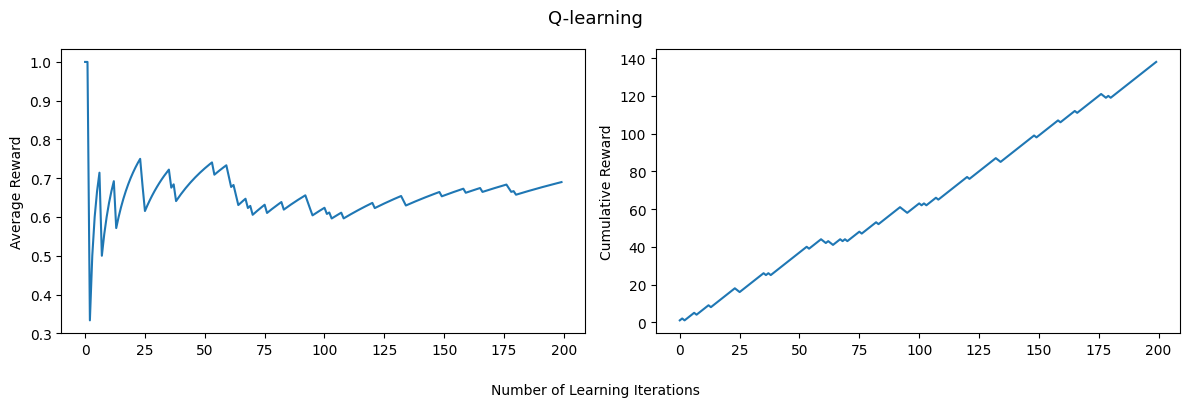

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot average_rewards
axs[0].plot(average_rewards)
axs[0].set_ylabel('Average Reward')

# Plot cum_rewards
axs[1].plot(cum_rewards)
axs[1].set_ylabel('Cumulative Reward')

fig.supxlabel('Number of Learning Iterations', fontsize=10)
fig.suptitle('Q-learning', fontsize=13)

plt.tight_layout()
plt.show()

### SARSA

In [32]:
# SARSA
print(f"Lambda {user._lambda} | p_aha {user._p_aha} \np_aha_factor {user._p_aha_factor} | posture_change_factor {user._posture_change_factor}\n")

Q, env, average_rewards, cum_rewards, idxs = user.simulation("SARSA", num_iterations=1200, explore_rate=0.1, max_delay=7)

print("Q values:")
print(Q)
print()

print("Optimal_actions:")
print(user.optimal_actions(Q))
print()

# Print Transition matrices after simulation
# print("Final transition matrices:")
# for i in range(env._T.shape[0]):
#     print(env._T[i])
#     print()

Lambda 0.0002794822847972976 | p_aha [0.12476267 0.17336983 0.13177875 0.15695596 0.1283043  0.12786289] 
p_aha_factor 1.0001690567217258 | posture_change_factor 0.9052293021504881

Q values:
[[0.72761779 0.3698387 ]
 [0.71648444 0.70009662]
 [0.40473893 0.81597543]
 [0.87318893 0.60169351]
 [0.         0.        ]
 [0.8692346  0.49723232]]

Optimal_actions:
[['EC' 'EC' 'EA']
 ['EC' 'EC' 'EC']]



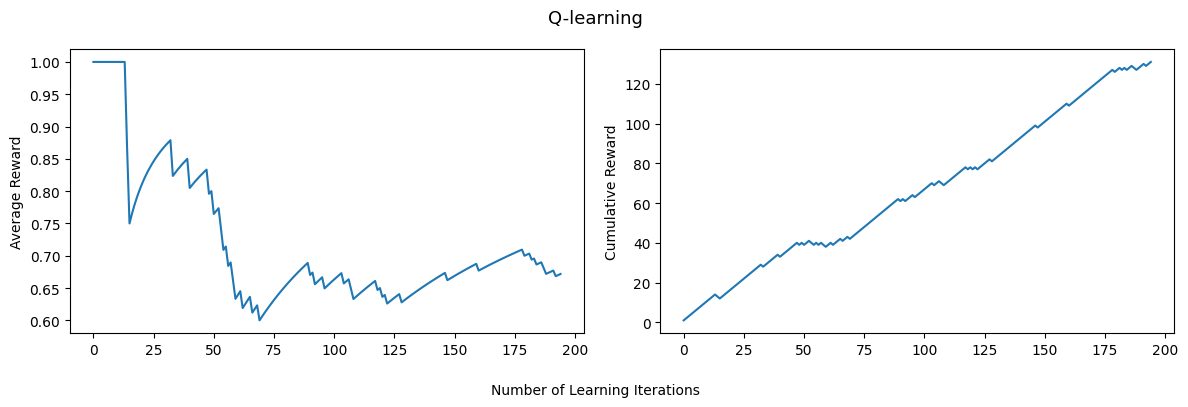

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot average_rewards
axs[0].plot(average_rewards)
axs[0].set_ylabel('Average Reward')

# Plot cum_rewards
axs[1].plot(cum_rewards)
axs[1].set_ylabel('Cumulative Reward')

fig.supxlabel('Number of Learning Iterations', fontsize=10)
fig.suptitle('Q-learning', fontsize=13)

plt.tight_layout()
plt.show()

## Simulating on multiple users

In [34]:
num_users = 10
users = generate_users(base_transition_matrix, lambda_range, p_aha_range, p_aha_factor_range, posture_change_factor_range, num_users=num_users)

### Q-learning

In [35]:
Qs = []
average_rewards = []
cum_rewards = []

for user in users:
    Q, env, avg_rewards, c_rewards, _ = user.simulation("Q", num_iterations=1200, explore_rate=0.1, max_delay=7)
    Qs.append(Q)
    average_rewards.append(avg_rewards)
    cum_rewards.append(c_rewards)

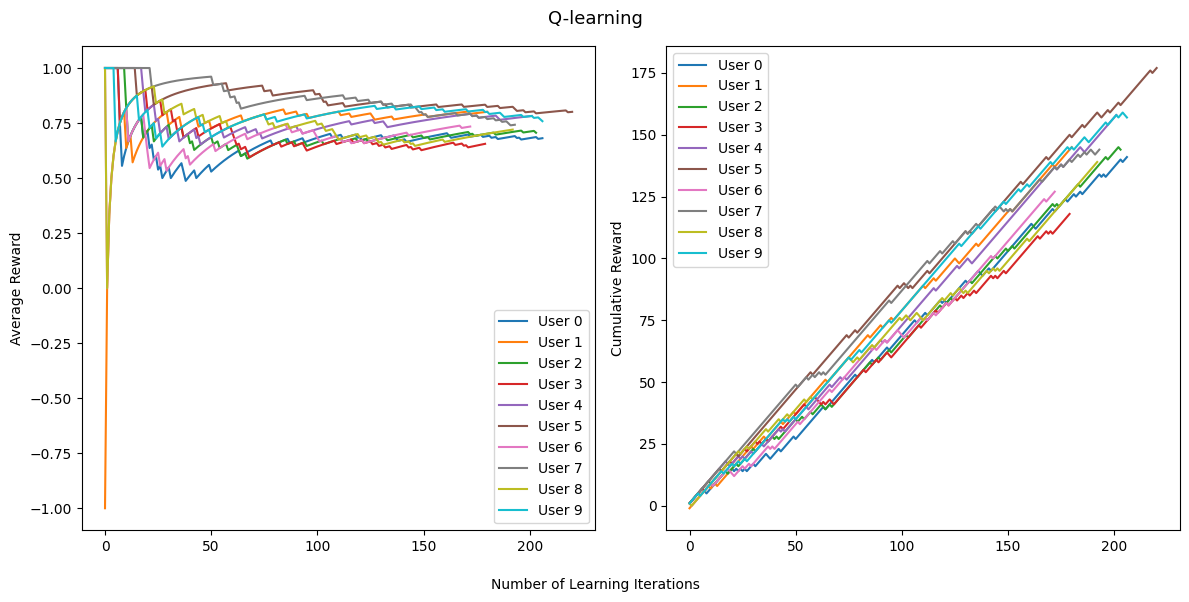

In [36]:
# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot average reward for each user
for idx in range(num_users):
    axs[0].plot(average_rewards[idx], label=f"User {idx}")
    axs[1].plot(cum_rewards[idx], label=f"User {idx}")

axs[0].set_ylabel("Average Reward")
axs[0].legend()

axs[1].set_ylabel("Cumulative Reward")
axs[1].legend()

fig.supxlabel('Number of Learning Iterations', fontsize=10)
fig.suptitle('Q-learning', fontsize=13)

plt.tight_layout()
plt.show()

### SARSA

In [37]:
Qs = []
average_rewards = []
cum_rewards = []

for user in users:
    Q, env, avg_rewards, c_rewards, _ = user.simulation("SARSA", num_iterations=1200, explore_rate=0.1, max_delay=7)
    Qs.append(Q)
    average_rewards.append(avg_rewards)
    cum_rewards.append(c_rewards)

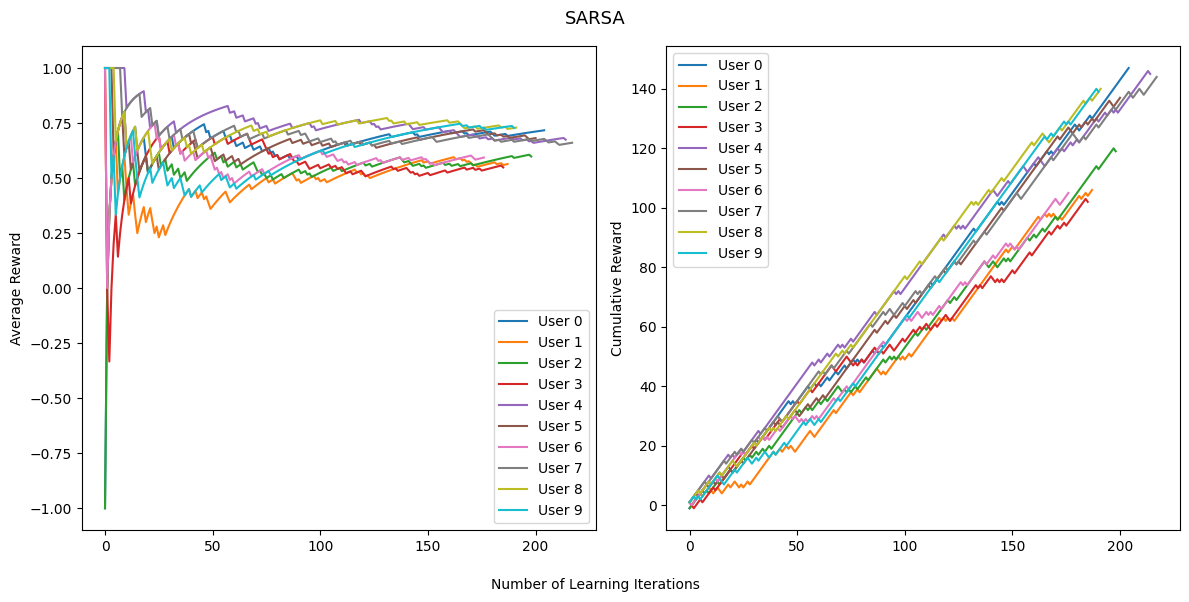

In [38]:
# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot average reward for each user
for idx in range(num_users):
    axs[0].plot(average_rewards[idx], label=f"User {idx}")
    axs[1].plot(cum_rewards[idx], label=f"User {idx}")

axs[0].set_ylabel("Average Reward")
axs[0].legend()

axs[1].set_ylabel("Cumulative Reward")
axs[1].legend()

fig.supxlabel('Number of Learning Iterations', fontsize=10)
fig.suptitle('SARSA', fontsize=13)

plt.tight_layout()
plt.show()